In [1]:
## Standard libraries
import os
import numpy as np
import random
import math

import json
from functools import partial
from PIL import Image

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()


from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms



%load_ext tensorboard


C:\Users\sirip\AppData\Local\Temp\ipykernel_2628\2634382035.py:16: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


<Figure size 640x480 with 0 Axes>

In [2]:
CHECKPOINT_PATH = 'saved_models/new/'

In [3]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/"
# Files to download
pretrained_files = ["tutorial15/ViT.ckpt", "tutorial15/tensorboards/ViT/events.out.tfevents.ViT",
                    "tutorial5/tensorboards/ResNet/events.out.tfevents.resnet"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name.split("/",1)[1])
    if "/" in file_name.split("/",1)[1]:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

In [4]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5) # [B, H', W', C, p_H, p_W]
    x = x.flatten(1,2)              # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2,4)          # [B, H'*W', C*p_H*p_W]
    return x

Files already downloaded and verified


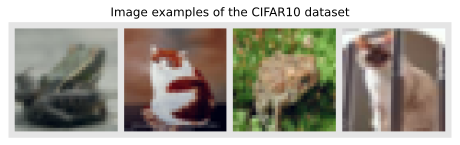

In [5]:
DATASET_PATH = 'data'

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize([0.49139968, 0.48215841, 0.44653091], 
                                                          [0.24703223, 0.24348513, 0.26158784])
                                     ])

val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])


# Visualize some examples
NUM_IMAGES = 4
CIFAR_images = torch.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(CIFAR_images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the CIFAR10 dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()




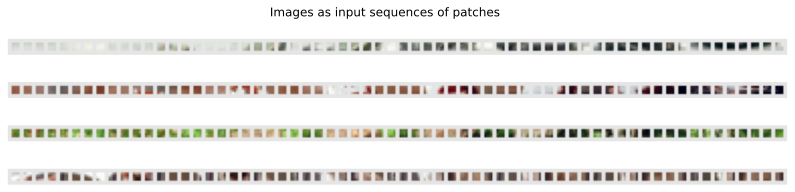

In [6]:
img_patches = img_to_patch(CIFAR_images, patch_size=4, flatten_channels=False)

fig, ax = plt.subplots(CIFAR_images.shape[0], 1, figsize=(14,3))
fig.suptitle("Images as input sequences of patches")
for i in range(CIFAR_images.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=64, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis('off')
plt.show()
plt.close()

In [2]:
from train import train_model

In [ ]:

model, results = train_model(model_kwargs={
                                'embed_dim': 256,
                                'hidden_dim': 512,
                                'num_heads': 8,
                                'num_layers': 6,
                                'patch_size': 4,
                                'num_channels': 3,
                                'num_patches': 64,
                                'num_classes': 10,
                                'dropout': 0.2
                            },
                            lr=3e-4)
print("ViT results", results)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified


Global seed set to 42


Files already downloaded and verified


Global seed set to 42


Files already downloaded and verified


Global seed set to 42


Files already downloaded and verified


Global seed set to 42
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | In sizes       | Out sizes
-------------------------------------------------------------------------
0 | model | VisionTransformer | 3.2 M  | [4, 3, 32, 32] | [4, 10]  
-------------------------------------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.781    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]